# Exploratory data analysis and visualizations 

Since we gathered the data ourselves, the data seems pretty clean.  Now we try to interpret the data.  First we recreate the data frame from [ProblemStatement](ProblemStatement.ipynb), this time adding titles to the columns.

In [1]:
# For data frames
import pandas as pd

# Numerical calculations
import numpy as np

# PCA for data exporation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# For plotting
import matplotlib.pyplot as plt

# Rereate the data frame using the output file from ProblemStatement
# Render the data frame
raw_data = pd.read_csv("ProblemStatementOutputs/179_28-03-2023_18-45-27.csv")
#raw_data # for debugging

## Basic comments analysis

The first function that follows takes as input a feature and outputs its corresponding attribute (post type, author, or tag).  The other functions are used to take a list of features and create a data frame with the number of occurrences of that feature, the total number of comments, the average number of comments, and the median number of comments.

In [2]:
# Input is a feature (under post type, author, or tag).
# Output is the attribute (Post type, Author(s), or Tags) for that feature.
def attr(feature):
    for column in raw_data.columns:
        #print("Column is "+str(column)+ ".") # for debugging
        for entry in raw_data[column]:
            with_commas = str(entry).split("; ")
            #print("Entry to check is "+str(with_commas)+".") # for debugging
            if feature in with_commas:
                attribute = column
                return attribute

# Input is one of the column titles "Post type", Author(s)", or "Tags" from the raw_data data frame.
# Output is an unordered list of the possible values for that attribute.
def attribute_features(attribute):
    all_features_with_repeats = []
    #print(raw_data[attribute]) # for debugging
    for feature_attr in raw_data[attribute]:
        #print(feature_attr) # for debugging
        with_commas = str(feature_attr).split("; ")
        for feature in with_commas:
            all_features_with_repeats.append(feature) 
    all_features_list = [*set(all_features_with_repeats)]
    return all_features_list

# Input is a list of features (with attributes Post type, Author(s), or Tags).
# Output is a data frame with the features and the frequency with which they occur in the data.
def frequency_of_features(features):
    frequency_list = []
    for i in range(len(features)):
        occurrences = 0
        for index, row in raw_data.iterrows():
            authors_in_row_list = str(row["Author(s)"]).split("; ")
            tags_in_row_list = str(row["Tags"]).split("; ")
            if (features[i] in row["Post type"]) or (features[i] in authors_in_row_list) or (features[i] in tags_in_row_list):
                occurrences = occurrences +1
        frequency_list.append(occurrences)
    dict = {
        "Features":features,
        "Frequency":frequency_list
    }    
    return pd.DataFrame(dict, columns=["Features", "Frequency"])    
                
# Input is one of the column titles "Post type", Author(s)", or "Tags" from the raw_data data frame.
# Output is a data frame containing the frequency, total number of comments, average number of comments, 
    # and median number of comments, sorted in by the average number of comments, then the median.
def comments_analysis(attribute):
    all_features_list = attribute_features(attribute)
    attr_total_comments_list, attr_avg_no_of_comments_list, attr_median_no_of_comments_list = ([] for i in range(3))
    for i in range(len(all_features_list)):
        comments = 0
        comments_data_list = []
        for index, row in raw_data.iterrows():
            attr_in_row_list = str(row[attribute]).split("; ")
            if all_features_list[i] in attr_in_row_list:
                comments = comments + int(row["No. of comments"])
                comments_data_list.append(row["No. of comments"])
        #print("comments_data_list =", comments_data_list) # for debugging
        #print("Mean of comments_data_list is "+ str(np.mean(comments_data_list))+".") # for debugging  
        #print("Median of comments_data_list is "+ str(np.median(comments_data_list))+".") # for debugging
        attr_total_comments_list.append(comments) 
        attr_avg_no_of_comments_list.append(np.mean(comments_data_list))
        attr_median_no_of_comments_list.append(np.median(comments_data_list))
    attr_comments_info = frequency_of_features(all_features_list)
    attr_comments_info["Total no. of comments"] = attr_total_comments_list
    attr_comments_info["Avg no. of comments"] = attr_avg_no_of_comments_list
    attr_comments_info["Median no. of comments"] = attr_median_no_of_comments_list    
    return attr_comments_info.sort_values(by = ["Avg no. of comments", "Median no. of comments"], ascending = [False, False])

We can visualize the comments analyses for each of Post type, Author(s), and Tags using bar graphs.

<AxesSubplot:ylabel='Features'>

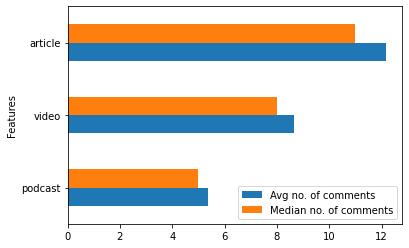

In [3]:
# Post type comments analysis
post_type_comments = comments_analysis("Post type")
post_type_comments.sort_values(by = ["Avg no. of comments", 
                                     "Median no. of comments"]).plot.barh(x="Features", 
                                                                        y=["Avg no. of comments", "Median no. of comments"])

Since there are 25 authors we take the top 20.



<AxesSubplot:ylabel='Features'>

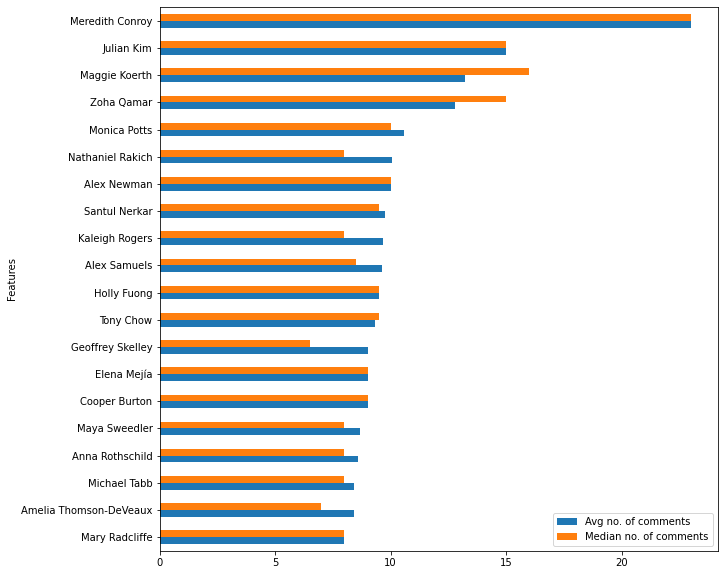

In [4]:
# Authors comments analysis
authors_comments = comments_analysis("Author(s)")
number_of_top_authors = 20
print("Since there are "+str(len(authors_comments["Features"]))+" authors we take the top "+str(number_of_top_authors)+".\n")
top_authors = authors_comments.head(number_of_top_authors).sort_values(by=["Avg no. of comments", "Median no. of comments"])
top_authors.plot(kind="barh", figsize=(10,10), x="Features", y=["Avg no. of comments", "Median no. of comments"])

Since there are 306 tags we take the top 20.



<AxesSubplot:ylabel='Features'>

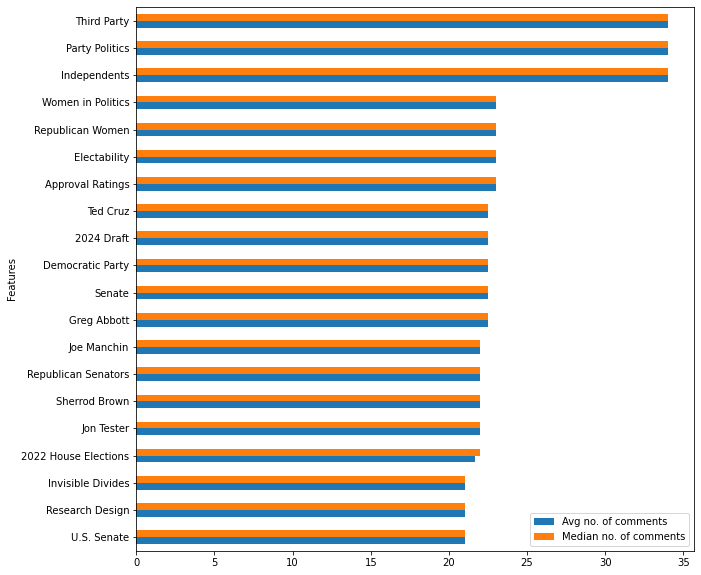

In [5]:
# Tags comments analysis
tags_comments = comments_analysis("Tags")
number_of_top_tags = 20
print("Since there are "+str(len(tags_comments["Features"]))+" tags we take the top "+str(number_of_top_tags)+".\n")
top_tags = tags_comments.head(number_of_top_tags).sort_values(by=["Avg no. of comments", "Median no. of comments"])
top_tags.plot(kind="barh", figsize=(10,10), x="Features", y=["Avg no. of comments", "Median no. of comments"])

## PCA analysis and pruning features

Some of the features (authors and tags) appear so few times that they are not very helpful.  Also, some of the tags like "Politics Podcast" and "Video" don't really give any information about the content, and since they appear frequently they distract the analysis of the rest of the data.  The following functions give ways to prune the features a little bit.  

In [21]:
# First input is a list of features, second input is a list of features to be removed.
# Output is the list of the list of features with that attribute, with the features in the input removed.
def prune(all_features, remove_features):
    pruned_features = all_features
    for feature in remove_features:
        pruned_features.remove(feature)
    return pruned_features    

# Input is a list of features (authors and tags).  Needs raw_data, attr, and frequency_of_features. 
# Output is the list with features that appear less than 2% of the time removed.
def most_used(features):
    frequencies = frequency_of_features(features)
    relevant_rows_list_with_repeats = []
    for feature in features:
        attribute = attr(feature)
        for entries in raw_data[attribute]:
            with_commas = str(entries).split("; ")
            if feature in with_commas:
                relevant_rows_list_with_repeats.append(np.array(raw_data.loc[raw_data[attribute] == entries].values.tolist()).flatten().tolist())            
    #print("Type for relevant_rows_list_with_repeats is "+str(type(relevant_rows_list_with_repeats))+".") # for debugging
    #print("Type for an item in relevant_rows_list_with_repeats is "+str(type(relevant_rows_list_with_repeats[0]))+".") # for debugging        
    #print("Relevant rows list (with repeats) is "+str(relevant_rows_list_with_repeats)+".") # for debugging
    relevant_rows_list_no_repeats = []
    for list_item in relevant_rows_list_with_repeats:
        if list_item not in relevant_rows_list_no_repeats:
            relevant_rows_list_no_repeats.append(list_item)
    total_data_points = len(relevant_rows_list_no_repeats) 
    print("Total number of data points = "+str(total_data_points)+", compared to "+str(len(raw_data.index))+".") # for debugging
    most_used = []
    for feature in features:
        #print("Feature is "+str(feature)+".") # for debugging
        #print("The row containing "+str(feature)+" is: "+str(frequencies.loc[frequencies["Features"]==feature])+".") # for debugging
        fraction_of_appearances = int(frequencies.loc[frequencies["Features"]==feature]["Frequency"])/total_data_points
        #print("Fraction of appearances is "+str(fraction_of_appearances)+".") # for debugging
        if fraction_of_appearances > 0.02:
            most_used.append(feature)
    return most_used 

# Most used tags
#most_used_tags = most_used(attribute_features("Tags")) 
#print(str(len(most_used_tags)) + " out of " +str(len(attribute_features("Tags")))+" tags selected.")

It seems like many of the tags in particular tend to appear together, and maybe certain authors produce content with certain tags, or other features are correlated.  We can do a PCA (principal component analysis) to find ways to group features (post type, authors, tags) that are correlated.  The following function creates a posts v. features matrix.

In [14]:
# Input is a list of any combination of features from post types, authors, or tags found in raw_data.
# Output is a data frame whose rows are the post titles and whose columns are the features.
    # (Must remove the labels when inputting data into PCA analysis.)
def PCA_input(features):
    matrix = [raw_data["Title"].values.tolist()]
    #print("Rows are:\n", matrix) # for debugging
    for feature in features:
        #print("Feature is "+feature+".\n") # for debugging
        occurrences_list = []
        for index, row in raw_data.iterrows():
            #print("Row for "+row["Title"]+":") # for debugging
            for attribute in raw_data.columns.values.tolist():
                #print("Attribute is "+attribute+".") # for debugging
                # Turn all values of an attribute into a list
                with_commas = str(row[attribute]).split("; ")
                if feature in with_commas:
                    #print(str(feature)+" is in "+str(row[attribute])+".") # for debugging
                    occurrences_list.append(1)
            #print("The length of the occurrences_list is "+str(len(occurrences_list))+".") # for debugging
            #print("The index is "+str(index)+".") # for debugging
            if len(occurrences_list) != index+1:
                occurrences_list.append(0) 
        #print("occurrences_list = ", occurrences_list, "\n") # for debugging       
        matrix.append(occurrences_list)      
    return pd.DataFrame(np.array(matrix).transpose(), columns = ["Post"]+features)               

We first run a PCA on the tags, after they have been pruned.

In [22]:
# Remove unuseful tags
#print("Initial tags are "+str(attribute_features("Tags"))+".") # for debugging
#print("There are "+str(len(attribute_features("Tags")))+" of them.") # for debugging
tags_pruned = prune(attribute_features("Tags"), ["Politics Podcast", 
                                                 "Video", "Featured video", "FiveThirtyEight Podcasts",
                                                "Slack Chat", "Do You Buy That"])
#print("tags_pruned =", tags_pruned) # for debugging
#print("Length of tags_pruned is "+str(len(tags_pruned))+".") # for debugging
final_tags = most_used(tags_pruned)
print("Final tags are "+ str(final_tags)+".  There are "+str(len(final_tags))+" of them.")
      
# Create the matrix for tags
posts_v_features_matrix = PCA_input(final_tags)
#print("Post v. features matrix is: \n", post_v_features_matrix) # for debugging

# Make the PCA objects
scaler = StandardScaler()
pca = PCA()

# Fit the PCA
features_scaled = scaler.fit_transform(posts_v_features_matrix[posts_v_features_matrix.columns[1:]])
pca.fit(features_scaled)

# Get the PCA components
component_vectors = pd.DataFrame(pca.components_.transpose(), index = posts_v_features_matrix.columns[1:])
component_vectors.sort_values(by = component_vectors.columns[0], ascending = False)

Total number of data points = 170, compared to 179.
Final tags are ['Democrats', 'Joe Biden', 'Debt Ceiling', 'House of Representatives', 'Speaker Of The House', 'Congress', 'Ron DeSantis', 'Mike Pence', 'State of the Union', 'Unions', 'China', 'The Biden Administration', 'Abortion', 'Parenting', '2022 Midterms', 'Inflation', 'Republican Party', 'Scandals', 'Senate Democrats', '2024 Democratic Primary', 'Nikki Haley', 'Polling', '2022 Election', '2022 In Review', 'Politics', 'Pollapalooza', 'Economy', '2024 Republican Primary', 'State Legislatures', 'Kyrsten Sinema', 'Donald Trump', '2024 Presidential Election', 'Federal Reserve', 'Jan. 6 Investigation', '2023 Election', 'Polls', 'Republicans', 'Red States', 'Partisanship', 'Kevin McCarthy', 'Ukraine', 'House Republicans', '2024 Election'].  There are 43 of them.


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
2024 Republican Primary,0.401516,0.154425,-0.087859,0.022625,-0.052763,-0.032780,0.008677,-0.004589,-0.068180,-0.040647,...,0.011048,-0.081553,-0.289324,-0.113569,0.079025,-0.036369,0.084243,-0.075711,0.000502,-0.595663
Donald Trump,0.363775,0.112610,-0.066343,-0.029906,0.084275,-0.037150,0.216816,-0.019698,-0.249454,0.108039,...,0.073972,-0.116151,0.053832,0.049986,0.172855,0.024221,0.465328,0.122954,-0.164538,0.504395
Ron DeSantis,0.359241,0.149186,-0.029362,0.058223,0.016998,-0.023355,0.074399,0.041007,0.012043,0.107930,...,0.025906,-0.329995,-0.027721,0.126663,-0.110433,0.012445,-0.464157,-0.174134,-0.158676,0.092038
Nikki Haley,0.351424,0.150776,-0.101350,0.041389,-0.105521,-0.048828,-0.137550,-0.012467,0.241260,-0.100015,...,0.038740,0.380676,-0.196848,-0.277272,0.092806,-0.133164,-0.352451,0.053730,0.052455,0.390654
Mike Pence,0.317754,0.152344,-0.091657,0.047042,-0.125395,-0.045029,-0.149201,-0.042548,0.221290,-0.100182,...,0.090010,0.071042,0.215802,0.134228,0.015270,0.074510,0.349814,0.043544,0.102415,-0.312492
2024 Election,0.307588,0.101200,-0.020508,0.023560,-0.131501,0.032838,-0.209908,-0.010844,0.168492,-0.132160,...,0.029081,-0.159246,0.290396,0.226059,-0.280622,0.127262,-0.051593,-0.065695,-0.038107,0.078928
2024 Presidential Election,0.237862,0.072575,0.149464,0.050356,0.163178,0.225081,0.106490,0.030445,-0.128067,0.242241,...,-0.127000,0.438725,0.083444,-0.171589,0.064809,-0.053235,0.002329,0.163693,0.154759,-0.134315
Politics,0.084600,-0.009279,0.086183,0.018074,0.276270,0.029127,0.202443,0.154778,0.159217,0.258598,...,0.069746,-0.086781,0.070830,0.091406,-0.114369,0.070094,0.054315,-0.045931,-0.010285,-0.090625
Republican Party,0.072976,0.047096,-0.033776,-0.068820,0.092861,0.101307,0.143569,-0.063945,-0.365557,0.250112,...,0.007096,0.046884,-0.024501,0.026058,-0.174793,0.067562,-0.117088,-0.250343,0.104008,0.007800
Jan. 6 Investigation,0.041667,-0.003916,-0.062784,-0.067684,0.029206,-0.059931,0.207799,-0.018164,-0.225929,-0.120993,...,0.025706,0.096602,0.040974,0.034005,-0.180416,-0.054336,-0.295368,0.010485,-0.015654,-0.168384
